In [11]:
%load_ext autoreload
%autoreload 2
import sys
import os
import matplotlib.pyplot as plt
import torch
from visualizer import visualize_random_image
from train import setup_train_args, build, test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
datasets = ["Kvasir", "CVC", "both"]
dataset = datasets[2]

In [13]:
args_train_student = setup_train_args(my_model="unet", temperature=4, alpha=0.9, dataset=dataset,
                                      data_root="./data_root/", batch_size=8, epochs=20, learning_rate=0.001)
from train import train_epoch

In [9]:
def train_student(args):
    (device,
     train_dataloader,
     test_dataloader,
     val_dataloader,
     Dice_loss,
     BCE_loss,
     KLT_loss,
     perf,
     student_model,
     _,
     optimizer,
     alpha,
     temperature) = build(args)


    loss_storage = []
    # performance metric is dice score
    perf_storage = []

    if not os.path.exists("./Trained_student_models/trained_alone/"):
        os.makedirs("./Trained_student_models/trained_alone/")

    prev_best_test = None
    if args.lrs == "true":
        if args.lrs_min > 0:
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="max", factor=0.5, min_lr=args.lrs_min, verbose=True
            )
        else:
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="max", factor=0.5, verbose=True
            )
    for epoch in range(1, args.epochs + 1):
        try:
            loss = train_epoch(student_model, device, train_dataloader,
                                       optimizer, epoch, Dice_loss, BCE_loss)

            test_measure_mean, test_measure_std = test(
                student_model, device, val_dataloader, epoch, perf
            )
            # add means and loss for vis
            loss_storage.append(loss)
            perf_storage.append(test_measure_mean)

        except KeyboardInterrupt:
            print("Training interrupted by user")
            sys.exit(0)
        if args.lrs == "true":
            scheduler.step(test_measure_mean)
        if prev_best_test == None or test_measure_mean > prev_best_test:
            # print("Saving...")
            # torch.save(
            #     {
            #         "epoch": epoch,
            #         "model_state_dict": student_model.state_dict()
            #         if args.mgpu is False
            #         else student_model.module.state_dict(),
            #         "optimizer_state_dict": optimizer.state_dict(),
            #         "loss": loss,
            #         "test_measure_mean": test_measure_mean,
            #         "test_measure_std": test_measure_std,
            #     },
            #     f"Trained_student_models/trained_alone/{student_model}_temp_{temperature}_alpha_{alpha}" + args.dataset + ".pt",
            # )
            prev_best_test = test_measure_mean
        visualize_random_image(test_dataloader, student_model)
    return loss_storage, perf_storage

Train Epoch: 1 [1288/1290 (100.0%)]	Average loss: 1.078740	Time: 14.536783
Test  Epoch: 1 [161/161 (100.0%)]	Average performance: 0.339141	Time: 1.099071


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


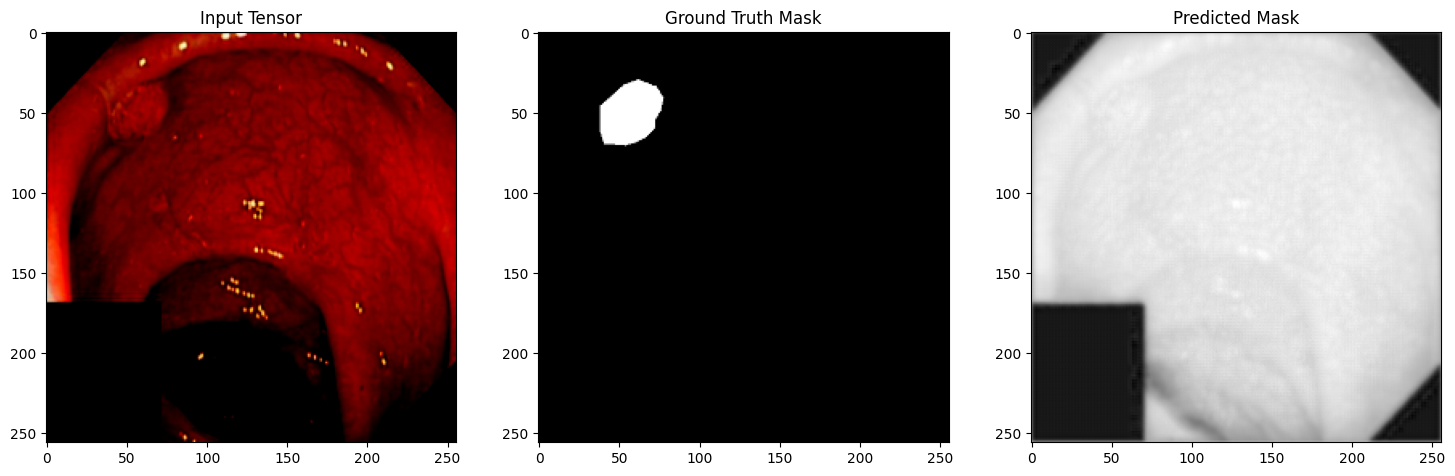

Train Epoch: 2 [1288/1290 (100.0%)]	Average loss: 1.032357	Time: 14.448972
Test  Epoch: 2 [161/161 (100.0%)]	Average performance: 0.242405	Time: 1.153846


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


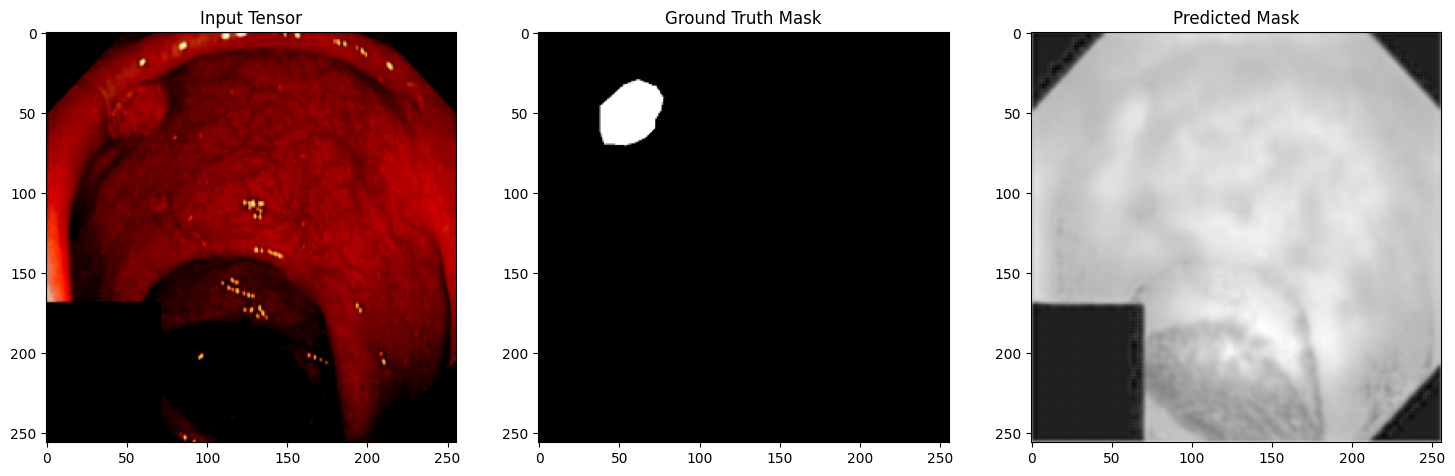

Train Epoch: 3 [1288/1290 (100.0%)]	Average loss: 1.016452	Time: 14.522076
Test  Epoch: 3 [161/161 (100.0%)]	Average performance: 0.195105	Time: 1.141505


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


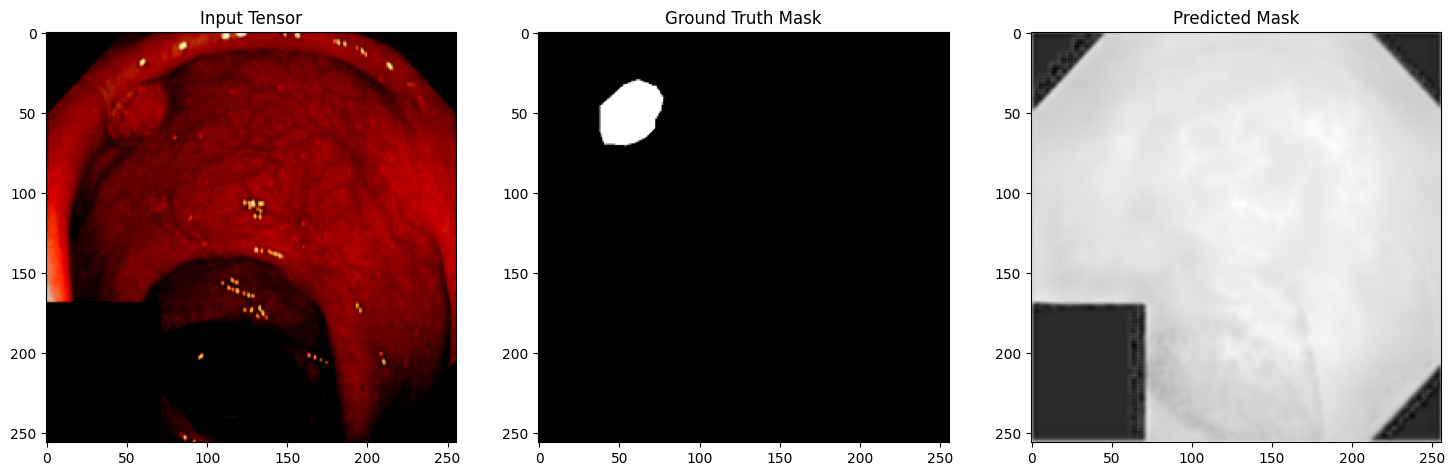

Train Epoch: 4 [1288/1290 (100.0%)]	Average loss: 0.993096	Time: 14.503866
Test  Epoch: 4 [161/161 (100.0%)]	Average performance: 0.411492	Time: 1.158466


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


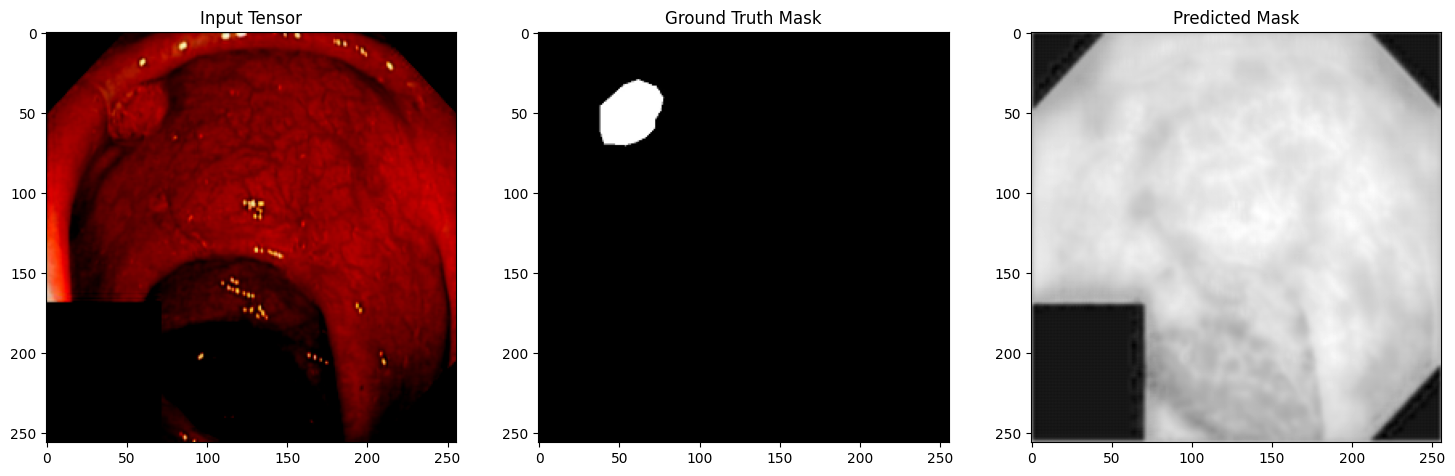

Train Epoch: 5 [64/1290 (5.0%)]	Loss: 0.771389	Time: 1.945389Training interrupted by user


AttributeError: 'tuple' object has no attribute 'tb_frame'

In [10]:
losses, perfs = train_student(args_train_student)